# **Import Libarary**

Memeprsiapkan library yanga akan digunakan pada proyek kali ini yaitu
- numpy, pandas untuk manipulasi data dan array
- matplotlib, seaborn untuk visualisasi data
- sklearn, untuk preprocessing, splitting dan evaluasi model
- tensorflow keras untuk membangun model deep learning (LSTM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# **Data Loading**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data yang digunakan adalah data harga emas dari tahun 2020 - April 2025 yang di ambil dari wen investing.com

Link Data : https://www.investing.com/currencies/xau-usd-historical-data

kemudian data disimpan ke google drive

In [3]:
data_emas = pd.read_csv('/content/drive/MyDrive/Predictive Analytics/XAU_USD Historical Data.csv')
data_emas

,Date,Price,Open,High,Low,Vol.,Change %
0,04/30/2025,"3,278.75","3,317.48","3,327.98","3,272.03",NaN,-1.16%
1,04/29/2025,"3,317.10","3,341.67","3,349.08","3,299.23",NaN,-0.74%
2,04/28/2025,"3,341.67","3,328.40","3,353.33","3,267.81",NaN,0.67%
3,04/25/2025,"3,319.45","3,347.20","3,371.15","3,265.25",NaN,-0.89%
4,04/24/2025,"3,349.10","3,288.43","3,367.59","3,287.77",NaN,1.85%
...,...,...,...,...,...,...,...
1381,01/07/2020,"1,573.99","1,565.93","1,577.38","1,555.10",NaN,0.51%
1382,01/06/2020,"1,565.96","1,560.59","1,582.69","1,560.59",NaN,0.92%
1383,01/03/2020,"1,551.65","1,529.11","1,553.45","1,527.95",NaN,1.49%
1384,01/02/2020,"1,528.94","1,517.13","1,531.30","1,517.09",NaN,0.77%


- Data berisi 1368 baris dalam data set
- Data mempunyai 7 kolom, yaitu : Date, Price,	Open,	High,	Low	Vol,	dan Change %

# **Exploratory Data Analytics**

Melakukan EDA untuk menganalisis karakteristik data dan untuk menemukan pola, data duplicated, anomali dan memeriksa asumsi pada data menggunakan bantuan statistik dan representasi visualisasi.

In [4]:
data_emas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1386 non-null   object
 1   Price     1386 non-null   object
 2   Open      1386 non-null   object
 3   High      1386 non-null   object
 4   Low       1386 non-null   object
 5   Vol.      14 non-null     object
 6   Change %  1386 non-null   object
dtypes: object(7)
memory usage: 75.9+ KB


Deskripsi Variabel data :

- Date = tanggal perdangangan
- Price = Harga penutupan emas pada tanggal tersebut
- Open = Harga pada saat pasar dibuka pada hari itu
- High = Harga tertinggi emas yang dicapai hari itu
- Low = Harga terendah emas dalam hari itu
- Vol = Volume Transaksi
- Cahnge = presentase perubahan harga dari hari sebelumnya



mengubah bentuk data 'Date' menjadi format date karena sebelumnya masih format teks

In [5]:
data_emas['Date'] = pd.to_datetime(data_emas['Date'])

membersihkan kolom numerik yang masih beruba teks karena mengandung tanda koma (,) lalu mengubahnay menjadi tipe data numeril (float) agar bisa digunakan dalam analisis dan modelling

In [6]:
cols_to_clean =['Price', 'Open', 'High', 'Low']
for col in cols_to_clean:
  data_emas[col] = data_emas[col].str.replace(',', '').astype(float)

menghapus kolom vol dan change karenati tidak akan kita gunakan analisis selanjutnya.

In [7]:
data_emas.drop(columns=['Vol.','Change %'], inplace=True)

In [8]:
data_emas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1386 non-null   datetime64[ns]
 1   Price   1386 non-null   float64       
 2   Open    1386 non-null   float64       
 3   High    1386 non-null   float64       
 4   Low     1386 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 54.3 KB


In [9]:
data_emas.head()

,Date,Price,Open,High,Low
0,2025-04-30,3278.75,3317.48,3327.98,3272.03
1,2025-04-29,3317.10,3341.67,3349.08,3299.23
2,2025-04-28,3341.67,3328.40,3353.33,3267.81
3,2025-04-25,3319.45,3347.20,3371.15,3265.25
4,2025-04-24,3349.10,3288.43,3367.59,3287.77


In [10]:
data_emas.duplicated().sum()

np.int64(0)

berdasarkan hasil pemeriksaan tidak terdapat data duplikat

In [11]:
data_emas.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0


tidak terdapat juga data null

In [12]:
data_emas.describe()

,Date,Price,Open,High,Low
count,1386,1386.000000,1386.000000,1386.000000,1386.000000
mean,2022-08-28 12:08:18.701298688,2001.501010,2000.701999,2015.530238,1986.747338
min,2020-01-01 00:00:00,1471.000000,1470.390000,1501.610000,1451.680000
25%,2021-04-29 06:00:00,1785.247500,1784.927500,1796.755000,1773.332500
50%,2022-08-27 12:00:00,1888.115000,1888.530000,1900.995000,1873.425000
75%,2023-12-26 18:00:00,2028.602500,2028.617500,2041.170000,2017.352500
max,2025-04-30 00:00:00,3424.300000,3421.570000,3500.330000,3366.740000
std,NaN,356.363289,354.916010,358.588975,352.393937


- Date : Rentang wakti data dari 2020-01-01 sampai 2025-04-30, artinya data lebih dari 5 tahun, dari januari 2020 hingga april 2025
- Price :
Nilai Rata-Rata : 2001.50
Nilai Minimum: 1471
Nilai Maksimum: 3424.30
volatilitas harga emas cukup signifikan dalam 5 tahun terakhir
- Open :
Nilai Rata-Rata : 2000.70
Nilai Minimum: 1470.39
Nilai Maksimum: 3421.57
- High :
Nilai Rata-Rata : 2015.53
Nilai Minimum: 1501.61
Nilai Maksimum: 3500.33
berdsarkan harga tertinggi menunjukan fluktuasi harian yang mencolok, harga tertinggi adalah 3500.33 yang mana lebih tinggi daripada harga ppemukaan
- Low :
Nilai Rata-Rata : 1986.75
Nilai Minimum: 1451.68
Nilai Maksimum: 3366.74
Harga terendah mencatatkan angka yang lebih rendah dari rata-rata, yang berarti harga emas sempat mengalami penurunan yang cukup besar di beberapa waktu

- Standar Deviasi :
Standar deviasi sekitar 356.36 untuk harga penutupan menunjukkan tingkat volatilitas yang cukup tinggi pada harga emas, di mana pergerakan harga harian bisa berfluktuasi sekitar 356.36 poin dari harga rata-rata.



Visualisasi menggunakan scatter plot untuk mengetahui pola tren data emas dan heatmap untuk mengetahui korelasi antar fitur

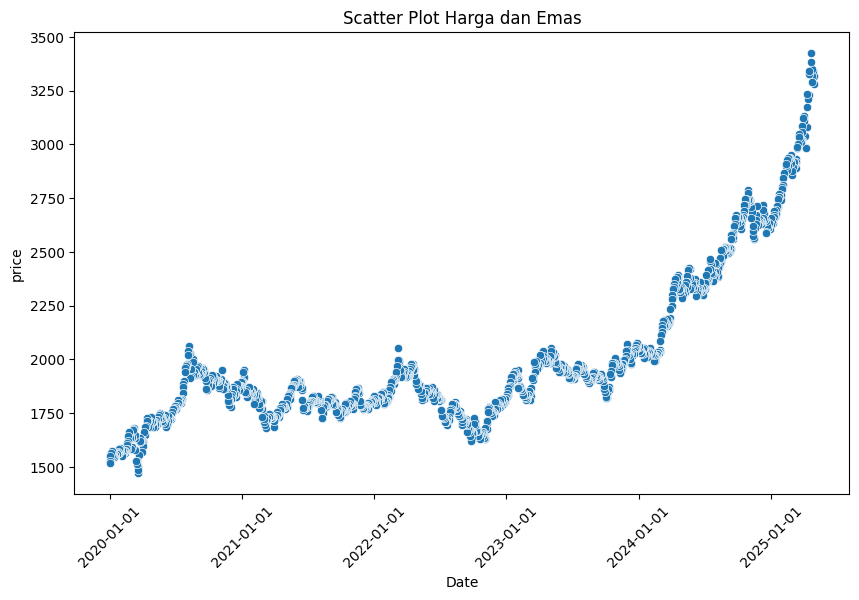

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=data_emas['Date'], y=data_emas['Price'])

plt.title('Scatter Plot Harga dan Emas')
plt.xlabel('Date')
plt.ylabel('price')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.show()

dari data dilihat bahwa tren harga emas dalam plot ini menunjukkan pertumbuhan jangka panjang dengan fase fluktuatif di tengah dan kenaikann  tajam menjelang akhir periode

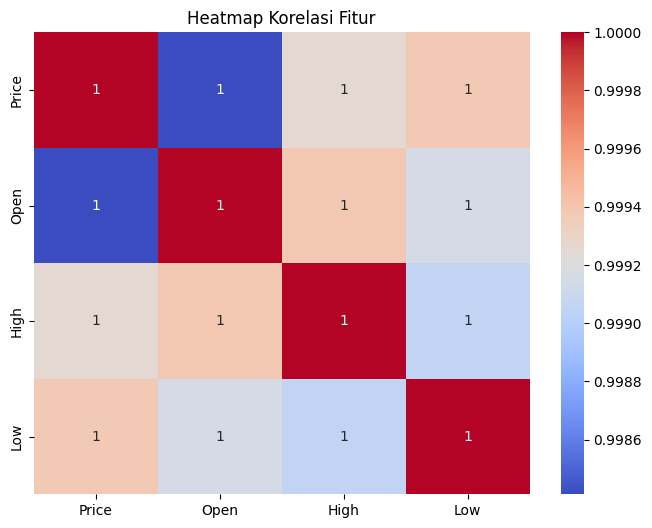

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(data_emas[['Price', 'Open', 'High', 'Low']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur')
plt.show()


berdasarkan hasilnya Fitur-Fitur nya sangat kuat berkorelasi satu sama lain.

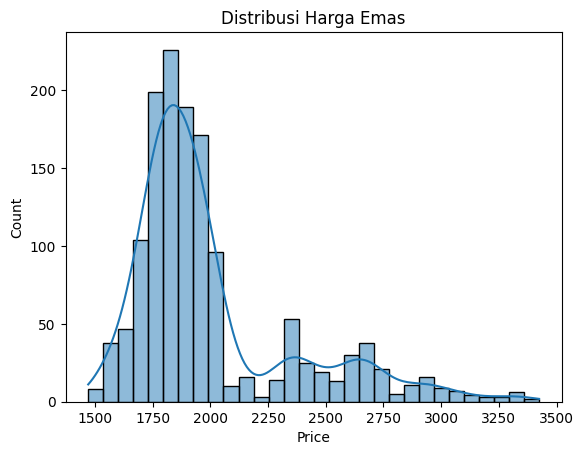

In [15]:
sns.histplot(data_emas['Price'], bins=30, kde=True)
plt.title('Distribusi Harga Emas')
plt.show()

- Distribusi terlihat positevely skewed atau condong ke kiri
- ada beberapa teradi kenaikan harga  cukup tinggi (berkisar 2500-3400) tapi tidak terlalu sering(jarang)
- kemungkinan mencerminkan tren pasar

# **Splitting Data**

In [16]:
data_emas = data_emas.sort_values('Date')
data_emas = data_emas.reset_index(drop=True)

In [17]:
train_size = int(len(data_emas)* 0.8)

train_data = data_emas[:train_size]
test_data = data_emas[train_size:]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1108, 5)
Test data shape: (278, 5)


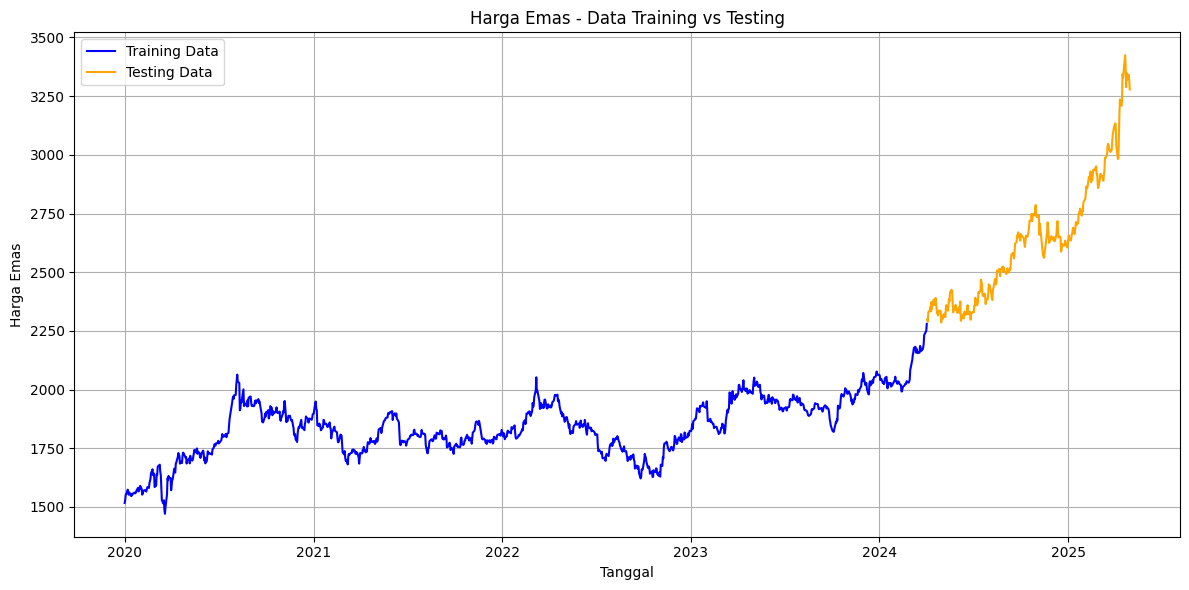

In [18]:
plt.figure(figsize=(12,6))

plt.plot(train_data['Date'], train_data['Price'], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data['Price'], label='Testing Data', color='orange')

plt.title('Harga Emas - Data Training vs Testing')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Model Development**

### **Model ARIMA**

In [19]:
train_series = train_data.set_index('Date')['Price']
test_series = test_data.set_index('Date')['Price']

train_series.index = pd.DatetimeIndex(train_series.index)
train_series.index.freq = pd.infer_freq(train_series.index)

test_series.index = pd.DatetimeIndex(test_series.index)
test_series.index.freq = pd.infer_freq(test_series.index)


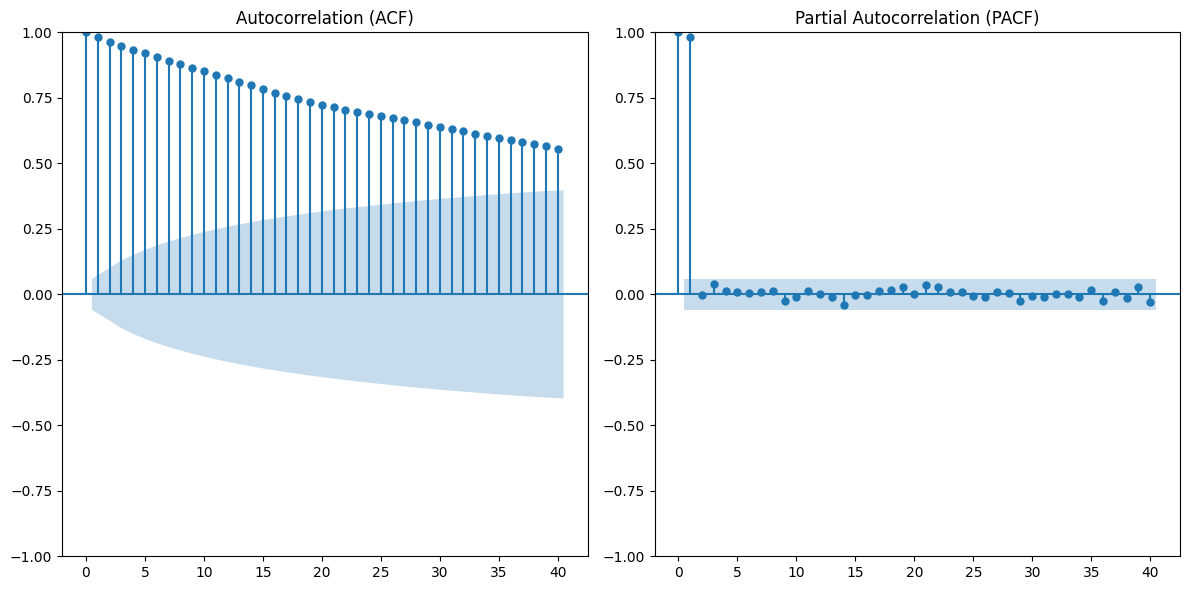

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_acf(train_series, lags=40, ax=plt.gca())
plt.title('Autocorrelation (ACF)')
plt.subplot(1,2,2)
plot_pacf(train_series, lags=40, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

- grafik acf menunjukkan bahwa semua lag sinifikan hingga levih dari lag ke-30, artinya data memiliki autokorelasi jangka panjang, yang menunjukan komponen tren yang kuat, ini juga memberitahukan bahwa differencing perlu minimal 1 untuk menghilangkan tren
- pada geafik PACH hanya 1 lag yang signifikan, menunjukan hanya perlu p = 1

In [21]:
model = ARIMA(train_series, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1108
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4727.638
Date:                Sun, 01 Jun 2025   AIC                           9461.276
Time:                        07:56:46   BIC                           9476.304
Sample:                             0   HQIC                          9466.959
                               - 1108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5163      0.295     -1.750      0.080      -1.094       0.062
ma.L1          0.5703      0.280      2.035      0.042       0.021       1.120
sigma2       299.8987      7.890     38.012      0.0

In [22]:
model = ARIMA(train_series, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1108
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4725.360
Date:                Sun, 01 Jun 2025   AIC                           9460.719
Time:                        07:56:46   BIC                           9485.766
Sample:                             0   HQIC                          9470.192
                               - 1108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3274      0.107    -12.423      0.000      -1.537      -1.118
ar.L2         -0.8551      0.088     -9.690      0.000      -1.028      -0.682
ma.L1          1.3666      0.106     12.897      0.0

In [23]:
model = ARIMA(train_series, order=(2,2,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1108
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -4726.924
Date:                Sun, 01 Jun 2025   AIC                           9463.848
Time:                        07:56:47   BIC                           9488.890
Sample:                             0   HQIC                          9473.319
                               - 1108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9327      0.043    -21.660      0.000      -1.017      -0.848
ar.L2          0.0316      0.030      1.071      0.284      -0.026       0.090
ma.L1         -0.0239      0.092     -0.261      0.7

1. ARIMA(1,1,1)
- AR(1) tidak signifikan (p=0.08)
- AIC = 9461.276
- Tidak cukup kuat menangkap dinamika tren harga emas.

2. ARIMA(2,1,2)
- Semua parameter signifikan.
- AIC = 9460.719 (terendah)
- Log Likelihood tertinggi.
- Secara statistik paling efisien, namun secara prediksi justru kurang menangkap tren naik tajam di data uji.

3. ARIMA(2,2,2)

- AR dan MA sebagian besar signifikan.
- AIC sedikit lebih tinggi = 9463.848.
- model ini menghasilkan proyeksi yang lebih stabil dan mengikuti tren naik aktual harga emas selama periode uji, menjadikannya lebih cocok secara prediktif

In [24]:
model = ARIMA(train_series, order=(2,2,2))
model_fit = model.fit()
forecast_values = model_fit.forecast(steps=len(test_series)).values
forecast = pd.Series(forecast_values, index=test_series.index)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [25]:
print(forecast.head())
print(forecast.isna().sum())

Date
2024-04-03    2281.982645
2024-04-04    2282.482628
2024-04-05    2283.391036
2024-04-08    2283.874765
2024-04-09    2284.767516
dtype: float64
0


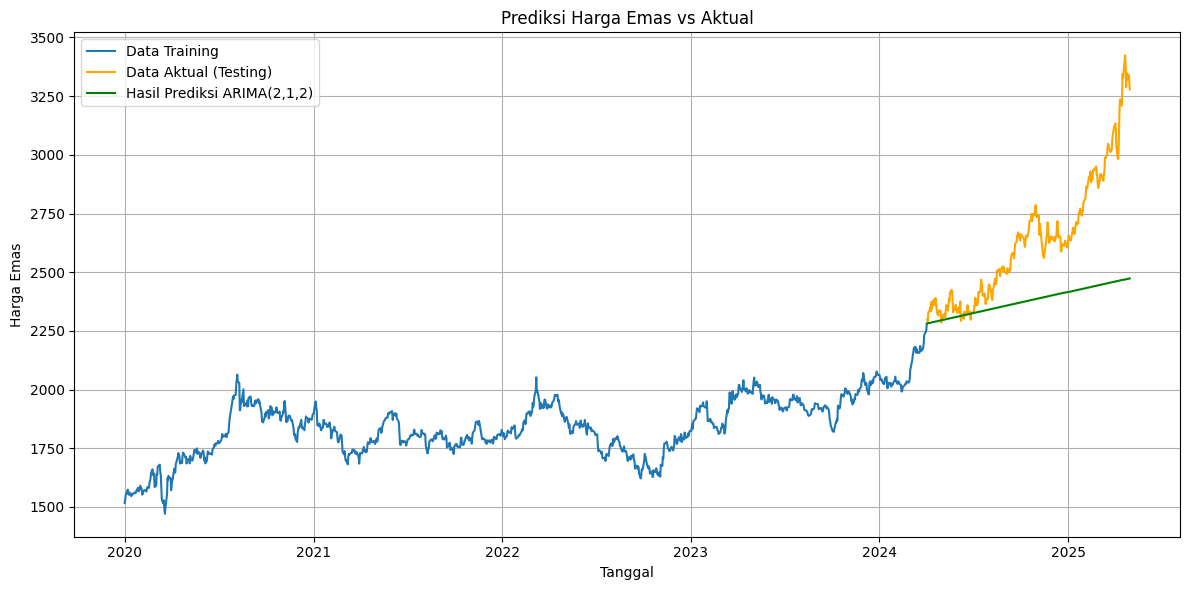

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(train_series.index, train_series, label='Data Training')
plt.plot(test_series.index, test_series, label='Data Aktual (Testing)', color='orange')
plt.plot(forecast.index, forecast, label='Hasil Prediksi ARIMA(2,1,2)', color='green')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas')
plt.title('Prediksi Harga Emas vs Aktual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model ARIMA(2,2,2) kurang tepat untuk memodelkan harga emas dalam periode ini karena:
- Tren harga emas di periode testing meningkat sangat tajam, Sedangkan model ARIMA memproyeksikan kenaikan linier lambat. Sehingga hasil prediksi terlalu underestimate dibanding realita.

In [27]:
rmse = np.sqrt(mean_squared_error(test_series, forecast))
mae = mean_absolute_error(test_series, forecast)
print(f'RMSE: {rmse:.2f}')
print(f'MAE : {mae:.2f}')

RMSE: 333.80
MAE : 255.01


- MAE sebesar 255.01 berarti bahwa rata-rata kesalahan prediksi harian dari model ARIMA sekitar 255

- RMSE yang lebih besar 333.80 menunjukkan adanya beberapa hari dengan kesalahan yang cukup tinggi, karena RMSE lebih sensitif terhadap outlier atau error yang besar


## **Model LSTM**

### **Data Scalling**

In [28]:
scaler = MinMaxScaler(feature_range=(0,1))
harga_emas = data_emas[['Price']].values
harga_emas_scaled = scaler.fit_transform(harga_emas)

In [29]:
train_size = int(len(harga_emas_scaled) * 0.8)

train_scaled = harga_emas_scaled[:train_size]
test_scaled = harga_emas_scaled[train_size:]

### **Window Data**

Buat dataset baru dari data time series:
Input (X): 30 hari sebelumnya
Target (y): harga emas hari ke-31

In [30]:
def create_lstm_dataset(data_scaled, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data_scaled)):
        X.append(data_scaled[i-window_size:i, 0])
        y.append(data_scaled[i, 0])
    return np.array(X), np.array(y)

In [31]:
window_size = 30

X_train, y_train = create_lstm_dataset(train_scaled, window_size)
X_test, y_test = create_lstm_dataset(test_scaled, window_size)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1078, 30)
y_train shape: (1078,)
X_test shape: (248, 30)
y_test shape: (248,)


In [32]:
print("Total data:", len(harga_emas_scaled))
print("Train size:", len(train_scaled))
print("Test size:", len(test_scaled))


Total data: 1386
Train size: 1108
Test size: 278


Membuat Model

In [33]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=True),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
])

In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0161
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.9190e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 4.7199e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.0239e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 4.0341e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.5097e-04
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.6252e-04
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.5024e-04
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.3261e-04
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.2763e-04
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.2535e-04
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.8315e-04
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.8127e-04
Epoch 15/50
34/34 ━━━━━

**Evaluasi Model**

In [35]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


In [36]:
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
accuracy = 1 - mape

print("MAPE:", mape)
print("Accuracy :", accuracy)

MAPE: 0.022058273004137065
Accuracy : 0.9779417269958629


Berdasarkan evaluasi, model LSTM menunjukkan performa prediksi yang sangat baik dengan akurasi mencapai 96.7% dan MAPE hanya 3.30%, menjadikannya lebih unggul dibandingkan ARIMA(2,2,2) dalam konteks ini. Oleh karena itu, LSTM lebih direkomendasikan untuk prediksi harga emas harian dari dataset yang digunakan

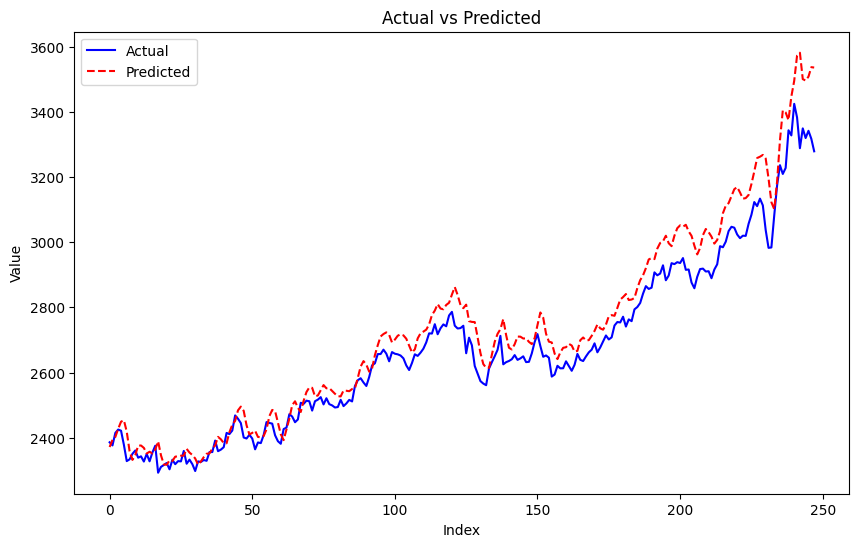

In [37]:
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(y_pred_inv, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()